In [24]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os
import pickle
import json

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [22]:
from bcnf.simulation.physics import physics_ODE_simulation
from bcnf.models.cnf import CondRealNVP
from bcnf.models.feature_network import FullyConnectedFeatureNetwork
from bcnf.train.train import train_CondRealNVP
from bcnf.utils import get_dir, ParameterIndexMapping
from bcnf.simulation.sampling import generate_data
from bcnf.simulation.resimulation import resimulate
from bcnf.utils import partconv1d, get_gaussian_kernel

In [28]:
TRAIN = False

## Data

In [3]:
T = 2
dt = 1/15

In [4]:
dataset_name = "test_resimulation_data_T2_dt_1_15"

if not os.path.exists(os.path.join(get_dir('data', 'bcnf-data'), dataset_name + '.pkl')):
    data = generate_data(
        n=2000,
        output_type="trajectory",
        dt=dt,
        T=T,
        config_file=os.path.join(get_dir("configs"), "throw_upwards_no_a.yaml"),
        verbose=True,
        break_on_impact=False,
        name=dataset_name
    )
else:
    with open(os.path.join(get_dir('data', 'bcnf-data'), dataset_name + '.pkl'), 'rb') as f:
        data = pickle.load(f)

100%|██████████| 2000/2000 [15:05<00:00,  2.21it/s, accepted=2000, ratio=0.269, rejected_distance=802, rejected_runaway=0, rejected_start_underground=1, rejected_visibility=4645]


In [5]:
all_parameters = list(data.keys())
print(all_parameters)

['x0_x', 'x0_y', 'x0_z', 'v0_x', 'v0_y', 'v0_z', 'g_x', 'g_y', 'g_z', 'w_x', 'w_y', 'w_z', 'b', 'm', 'a_x', 'a_y', 'a_z', 'cam_radian_array', 'r', 'A', 'Cd', 'rho', 'cam_radius', 'cam_angles', 'cam_heights', 'trajectory']


In [6]:
parameter_selection = ['x0_x','x0_y','x0_z','v0_x','v0_y','v0_z', "g_z",'w_x','w_y','w_z','b','A','Cd','rho','m','a_x','a_y','a_z','r']
for p in parameter_selection:
    assert p in all_parameters

In [11]:
X_list = [physics_ODE_simulation(T=T, dt=dt, **{k: data[k][i] for k in all_parameters}) for i in tqdm(range(len(data['x0_x'])))]

100%|██████████| 2000/2000 [00:02<00:00, 957.97it/s] 


In [12]:
parameter_index_mapping = ParameterIndexMapping(parameter_selection)

In [13]:
X = np.array(X_list)
y = parameter_index_mapping.vectorize(data)

print(f'{X.shape=}')
print(f'{y.shape=}')

X.shape=(2000, 30, 3)
y.shape=(2000, 19)


In [14]:
STEPS = X.shape[1]
d = X.shape[2]

print(f'{STEPS=}')
print(f'{d=}')

STEPS=30
d=3


In [15]:
# Split data into training and validation
X_train, X_val, y_train, y_val = train_test_split(X.reshape(X.shape[0], -1), y, test_size=0.2, random_state=2024_03_25)

X_train = X_train.reshape(-1, STEPS, d)
X_val = X_val.reshape(-1, STEPS, d)

X_train_tensor = torch.tensor(X_train.reshape(X_train.shape[0], -1), dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)

X_val_tensor = torch.tensor(X_val.reshape(X_val.shape[0], -1), dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)

print(f'{X_train_tensor.shape=}')
print(f'{y_train_tensor.shape=}')
print(f'{X_val_tensor.shape=}')
print(f'{y_val_tensor.shape=}')

X_train_tensor.shape=torch.Size([1600, 90])
y_train_tensor.shape=torch.Size([1600, 19])
X_val_tensor.shape=torch.Size([400, 90])
y_val_tensor.shape=torch.Size([400, 19])


## Model

In [23]:
config = {
    "data_kwargs": {
        "T": T,
        "dt": dt,
        "dataset_name": dataset_name,
        "parameter_selection": parameter_selection,
        "steps": STEPS,
    },
    "optimizer_kwargs": {
        "lr": 2e-4
    },
    "lr_scheduler_kwargs": {
        "mode": "min",
        "factor": 0.5,
        "patience": 250,
        "threshold_mode": "abs",
        "threshold": 1e-1,
    },
    "model_kwargs":{
        'size': 19,
        'condition_size': 80,
        'model_nested_size': 16,
        'model_nested_layers': 7,
        'model_n_blocks': 32,
        'model_act_norm': True,
        'model_dropout': 0.383,
        'feature_network_input_:size': 30,
        'feature_network_hidden_size': 59,
        'feature_network_hidden_layers': 0,
        'feature_network_dropout': 0.244,
    }
}

In [17]:
feature_network = FullyConnectedFeatureNetwork(
    sizes = [config['model_kwargs']['feature_network_dropout']] + [config['condition_size']],
    dropout=config['model_kwargs']['feature_network_dropout']
).to(device)

In [18]:
cnf = CondRealNVP(
    size=config['model_kwargs']['size'],
    nested_sizes=[config['model_kwargs']['model_nested_size']] * config['model_kwargs']['model_nested_layers'],
    n_blocks=config['model_kwargs']['model_n_blocks'],
    dropout=config['model_kwargs']['model_dropout'],
    n_conditions=config['condition_size'],
    act_norm=config['model_kwargs']['model_act_norm'],
    feature_network=feature_network,
    parameter_index_mapping=parameter_index_mapping).to(device)

optimizer = torch.optim.Adam(cnf.parameters(), lr=config['optimizer_kwargs']['lr'])

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode=config['lr_scheduler_kwargs']['mode'],
    factor=config['lr_scheduler_kwargs']['factor'],
    patience=config['lr_scheduler_kwargs']['patience'],
    threshold_mode=config['lr_scheduler_kwargs']['threshold_mode'],
    threshold=config['lr_scheduler_kwargs']['threshold'],
)

In [19]:
print(f'Number of parameters: {cnf.n_params:,}')

Number of parameters: 117,066


## Training / Loading

In [25]:
model_name = 'bcnf_traj'

In [20]:
loss_history = {}

In [29]:
if TRAIN:
    train_CondRealNVP(
        model=cnf,
        optimizer=optimizer,
        lr_scheduler=lr_scheduler,
        X_train=X_train_tensor,
        y_train=y_train_tensor,
        X_val=X_val_tensor,
        y_val=y_val_tensor,
        n_epochs=50_000,
        val_loss_patience=500,
        val_loss_tolerance=1e-1,
        val_loss_tolerance_mode="abs",
        batch_size=256,
        loss_history=loss_history
    )

    torch.save(cnf.state_dict(), os.path.join(get_dir('models', 'bcnf-models', model_name, create=True), f"state_dict.pt"))

    with open(os.path.join(get_dir('models', 'bcnf-models', model_name, create=True), 'loss_history.pkl'), 'wb') as f:
        pickle.dump(loss_history, f)

    with open(os.path.join(get_dir('models', 'bcnf-models', model_name, create=True), 'config.json'), 'w') as f:
        json.dump(config, f)

else:
    cnf.load_state_dict(torch.load(os.path.join(get_dir('models', 'bcnf-models', model_name), "state_dict.pt")))

    with open(os.path.join(get_dir('models', 'bcnf-models', model_name), 'loss_history.pkl'), 'rb') as f:
        loss_history = pickle.load(f)

    with open(os.path.join(get_dir('models', 'bcnf-models', model_name), 'config.json'), 'r') as f:
        config = json.load(f)

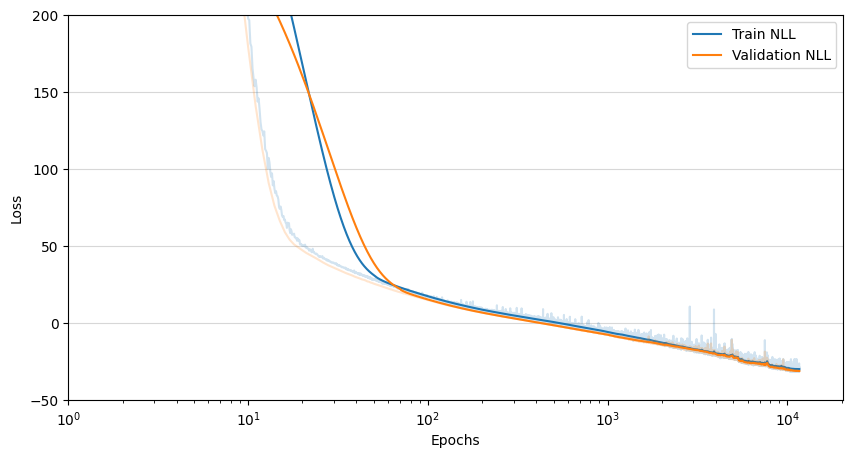

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

epochs = np.array([e for e, _ in loss_history['train']])
losses = np.array([l for _, l in loss_history['train']])

ax.plot(epochs, losses, alpha=0.2, color='C0')
ax.plot(epochs, partconv1d(losses, kernel=get_gaussian_kernel(sigma=100)), label='Train NLL', color='C0')

epochs = np.array([e for e, _ in loss_history['val']])
losses = np.array([l for _, l in loss_history['val']])

ax.plot(epochs, losses, alpha=0.2, color='C1')
ax.plot(epochs, partconv1d(losses, kernel=get_gaussian_kernel(sigma=20)), label='Validation NLL', color='C1')

ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')

ax.set_xscale('log')
ax.set_ylim(-50, 200)
ax.set_xlim(1, None)
ax.grid(axis='y', alpha=0.5)

ax.legend();

In [35]:
cnf.eval();

## Resimulation

In [ ]:
# https://github.com/scipy/scipy/issues/15940
X_resimulation = resimulate(
    model=cnf,
    T=T,
    dt=dt,
    y_hat=None,
    data_dict=data,
    X=X_val_tensor,
    m_samples=1_000,
    break_on_impact=False
)

In [42]:
X_resimulation.shape

(400, 1000, 30, 3)

## Resimulation Error

In [43]:
X_val.shape

(400, 30, 3)

In [65]:
X_error = (X_resimulation - X_val[:, None, :, :])**2

/tmp/ipykernel_10720/3212975733.py:1: RuntimeWarning: overflow encountered in square
  X_error = (X_resimulation - X_val[:, None, :, :])**2


In [77]:
X_errors = np.nanmean(X_error, axis=(1, 3))

In [81]:
X_errors

array([[6.23831716e+00, 5.79259654e+16, 3.11169719e+19, ...,
                   inf,            inf,            inf],
       [4.13098539e+00, 2.61718542e+16, 3.04838302e+18, ...,
        6.64143870e+21, 6.66282022e+21, 6.67873816e+21],
       [4.86452212e+00, 1.15173023e+17, 1.30739851e+21, ...,
        1.07258145e+22, 1.09665378e+22, 1.12197034e+22],
       ...,
       [3.41724780e+00, 5.83907968e+15, 7.21752933e+17, ...,
        2.18885076e+20, 2.18885076e+20, 2.18885076e+20],
       [8.13210278e+00, 2.88935050e+16, 3.83504126e+18, ...,
        1.43646445e+21, 1.46212397e+21, 1.48906905e+21],
       [7.32348653e+00, 2.25178945e+16, 2.88387870e+21, ...,
        6.72647214e+21, 6.72647214e+21, 6.72647214e+21]])

In [87]:
np.nanmedian(X_errors)

6.559356403273682e+20

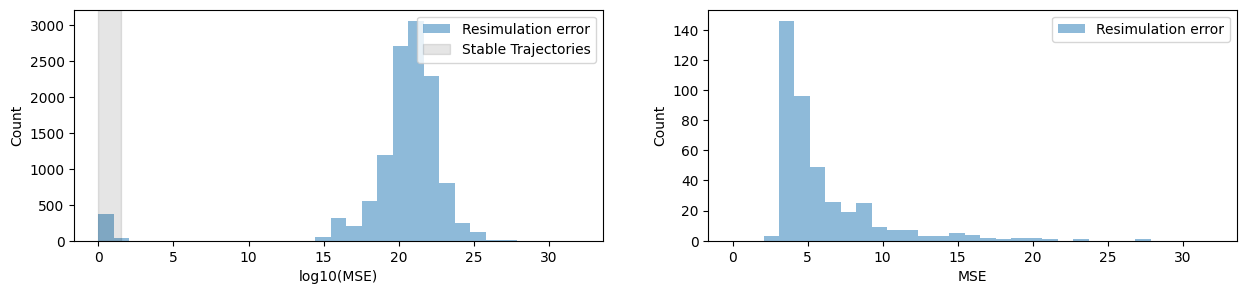

In [103]:
fig, axes = plt.subplots(1, 2, figsize=(15, 3))

axes[0].hist(np.log10(X_errors.flatten()), bins=np.linspace(0, 32, 32), alpha=0.5, label='Resimulation error');
axes[0].axvspan(0, np.log10(32), alpha=0.1, color='k', label='Stable Trajectories')

axes[0].set_xlabel('log10(MSE)')
axes[0].set_ylabel('Count')

axes[0].legend()

axes[1].hist(X_errors.flatten(), bins=np.linspace(0, 32, 32), alpha=0.5, label='Resimulation error');

axes[1].set_xlabel('MSE')
axes[1].set_ylabel('Count')

axes[1].legend()

In [104]:
# For each simulation i, find the indices j (sample), t (timestep), k in [i, j, t, -1] where X_resimulation changes sign from positive to negative
impact_indices = [np.where(np.diff((X_resimulation[i, :, :, -1] > 0).astype(int), axis=1) == -1) for i in range(X_resimulation.shape[0])]

# Get the potitions at the impact indices for each simulation i and sample j at time t
X_resimulation_impact_positions = [X_resimulation[i, impact_indices[i][0], impact_indices[i][1], :] for i in range(X_resimulation.shape[0])]

In [105]:
true_impact_indices = np.where(np.diff((X_val[:, :, -1] > 0).astype(int)) == -1)

X_val_impact_positions = X_val[true_impact_indices[0], true_impact_indices[1]]

In [110]:
true_impact_indices[0]

array([ 18,  56, 112, 156, 162, 186, 212, 296, 318])

In [111]:
show_index = 18

# Check if the desired validation trajectory has an impact
assert show_index in true_impact_indices[0]

X_val_impact_position = X_val[show_index, true_impact_indices[1][np.where(true_impact_indices[0] == show_index)[0]][0], :] 

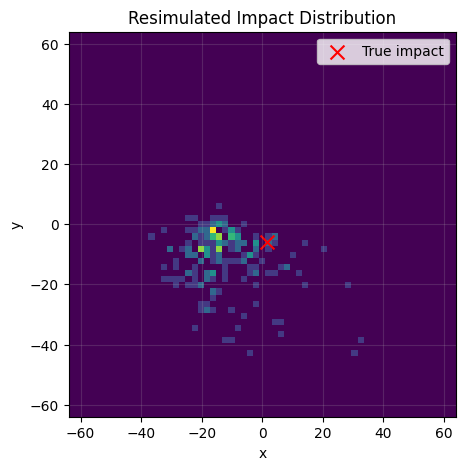

In [112]:
# Plot a heatmap of X_resimulation[0, impact_indices, :2]
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist2d(X_resimulation_impact_positions[show_index][:, 0], X_resimulation_impact_positions[show_index][:, 1], bins=np.linspace(-64, 64, 64), cmap='viridis');
ax.scatter(X_val_impact_position[0], X_val_impact_position[1], color='red', s=100, marker='x', label='True impact')
ax.grid(axis='both', alpha=0.2);
ax.set_xlabel('x');
ax.set_ylabel('y');
ax.set_title('Resimulated Impact Distribution');
ax.legend();

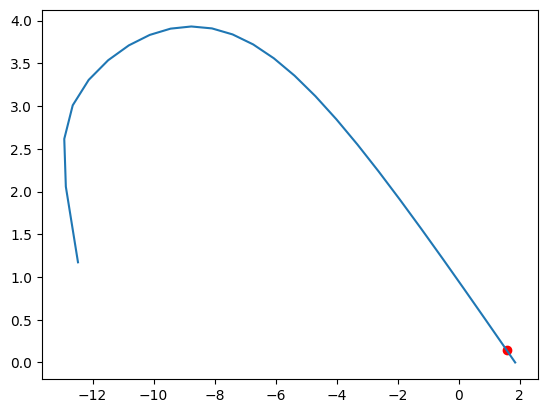

In [113]:
plt.plot(X_val[show_index, :, 0], X_val[show_index, :, -1], label='True trajectory');
plt.scatter(X_val_impact_position[0], X_val_impact_position[-1], color='red', label='Impact');

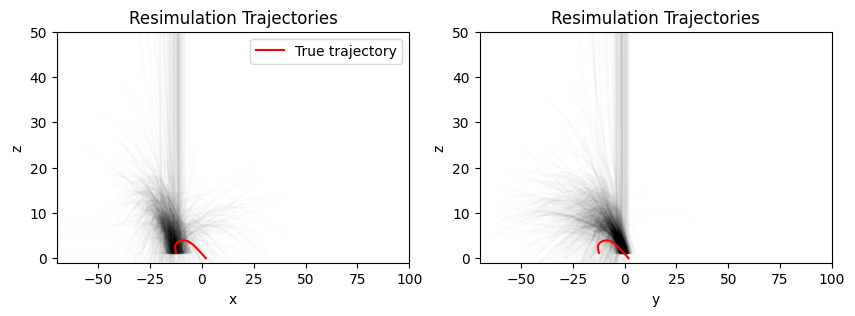

In [114]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

n_trajectories = 1000
max_time = 1000


for i, (ax, ax_name) in enumerate(zip(axes, ['x', 'y'])):
    ax.plot(X_resimulation[show_index, :n_trajectories, :max_time, i].T, X_resimulation[show_index, :n_trajectories, :max_time, -1].T, alpha=0.01, color='black');
    ax.plot(X_val[show_index, :, 0], X_val[show_index, :, 2], label='True trajectory', color='red');
    ax.set_xlim(-70, 100)
    ax.set_ylim(-1, 50)
    ax.set_xlabel(ax_name);
    ax.set_ylabel('z');
    ax.set_title('Resimulation Trajectories');

axes[0].legend();